## Cancer Detection with the Inception v3 Pre-trained Model 

This is a first attempt implementation of the inception v3 pre trained model developed by good. In choosing this model, I researched several pre trained models to determine which could work best for my needs. We learned in lecture, this model performs well in prediciton of medical imaging and an article by medium stated, "InceptionV3 was designed to be computationally efficient while maintaining high accuracy on image classification tasks". 

Computational effiecency was important to be because the model I had developed on my own took a long time to run on my machine. I wanted something that allowed me to iterate faster and perform atleast similarlly or better to my model. 

Below is my implmentation of the v3 model. Most of what I have done would be considered out of the box. 

The model still augments the pictures to help prevent the model overfitting but the required input size is 299x299. The optimizer is "Adam" and there is a learning rate scheduler set to reduce by a factor of .1 every 7 steps. Epochs is set to 15 after determining through a couple runs this was about the most needed to stabalize the model. 

In [ ]:
import pandas as pd
import os
import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms


C:\Users\vinins2\Anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
C:\Users\vinins2\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\vinins2\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=In

Epoch [1/15], Step [1/32], Loss: 4.1017
Epoch [1/15], Step [11/32], Loss: 2.8175
Epoch [1/15], Step [21/32], Loss: 2.6954
Epoch [1/15], Step [31/32], Loss: 2.2266
Epoch [1/15], Train Loss: 2.5074, Val Loss: 0.4367
Epoch [2/15], Step [1/32], Loss: 1.5508
Epoch [2/15], Step [11/32], Loss: 1.5884
Epoch [2/15], Step [21/32], Loss: 1.8697
Epoch [2/15], Step [31/32], Loss: 0.9632
Epoch [2/15], Train Loss: 1.3302, Val Loss: 0.4842
Epoch [3/15], Step [1/32], Loss: 1.1134
Epoch [3/15], Step [11/32], Loss: 1.0123
Epoch [3/15], Step [21/32], Loss: 1.0913
Epoch [3/15], Step [31/32], Loss: 0.7000
Epoch [3/15], Train Loss: 0.9752, Val Loss: 0.4136
Epoch [4/15], Step [1/32], Loss: 0.5205
Epoch [4/15], Step [11/32], Loss: 0.5166
Epoch [4/15], Step [21/32], Loss: 0.8275
Epoch [4/15], Step [31/32], Loss: 0.6545
Epoch [4/15], Train Loss: 0.7545, Val Loss: 0.4430
Epoch [5/15], Step [1/32], Loss: 0.4202
Epoch [5/15], Step [11/32], Loss: 0.6323
Epoch [5/15], Step [21/32], Loss: 0.7654
Epoch [5/15], Step [31

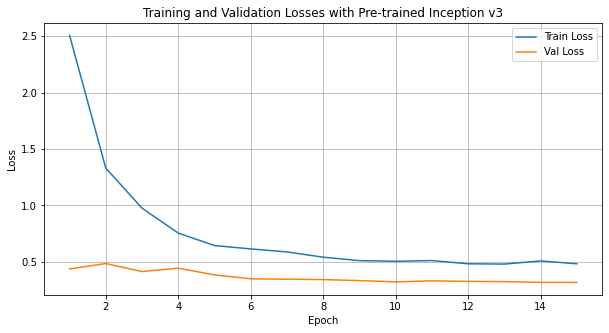

In [5]:
# Define transformation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(299),  # Inception v3 requires 299x299 input size
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
])

# Define the path to the train labels CSV file
csv_file_path = r'MSDS\DL\histopathologic-cancer-detection\train_labels.csv'

# Load the train labels CSV file
train_df = pd.read_csv(csv_file_path)

# Create a dictionary of labels from the DataFrame
labels_dict = {row['id']: row['label'] for idx, row in train_df.iterrows()}

# directory
train_dir = r'MSDS\DL\histopathologic-cancer-detection\train'

# Get all image IDs from the train directory
train_image_ids = [os.path.splitext(os.path.basename(f))[0] for f in glob.glob(os.path.join(train_dir, '*.tif'))]

# Split the train data into train and validation sets
train_ids, val_ids = train_test_split(train_image_ids, test_size=0.1, random_state=42)

# Define CancerDataset class
class CancerDataset(Dataset):
    def __init__(self, datafolder, image_ids, transform=None, labels_dict={}):
        self.datafolder = datafolder
        self.image_ids = image_ids
        self.transform = transform
        self.labels_dict = labels_dict

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_name = os.path.join(self.datafolder, f"{self.image_ids[idx]}.tif")
        image = Image.open(img_name)
#         print(f"Original image size: {image.size}")
        if self.transform:
            image = self.transform(image)
        label = self.labels_dict.get(self.image_ids[idx], 0)
        return image, label

# Instantiate datasets
train_dataset = CancerDataset(datafolder=train_dir, image_ids=train_ids[:1000], transform=train_transform, labels_dict=labels_dict)  # Use a subset for quick testing
val_dataset = CancerDataset(datafolder=train_dir, image_ids=val_ids[:200], transform=val_transform, labels_dict=labels_dict)  # Use a subset for quick testing

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Load pre-trained Inception v3 model
model = models.inception_v3(pretrained=True)

# Modify the final fully connected layer for 2 classes (binary)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Define the learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Initialize lists to store losses
train_losses = []
val_losses = []

# Train the model
num_epochs = 15 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, aux_outputs = model(images)  # Inception v3 has auxiliary outputs
        loss1 = criterion(outputs, labels)
        loss2 = criterion(aux_outputs, labels)
        loss = loss1 + 0.4 * loss2  # Combine both losses
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * images.size(0)  # Multiply by batch size

        if i % 10 == 0:  # Print progress every 10 batches
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    
    # Calculate average training loss for the epoch
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    
    # Validation phase
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)  # Multiply by batch size
    
    # Calculate average validation loss for the epoch
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    
    # Print and store losses
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')
    
    # Step the learning rate scheduler
    scheduler.step()

# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses with Pre-trained Inception v3')
plt.legend()
plt.grid(True)
plt.show()


Reviewing the output, the model does not appear to perform poorly. Its with a Train Loss of about .48 and a Validation Loss of about .32. This is similar to the model I created but arrived at this in a much shorter amount of time. My model tool roughly 1.5 hours to run and this one takes about 20 minutes. 

I am going to iterate on this model to see if I can improve it further. 